In [3]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import glob
import yaml
from pandas.api.types import is_numeric_dtype

from pathlib import Path

In [4]:
%run ../0_Config.ipynb

In [5]:
%run ../0_UDFs.ipynb

In [6]:
# required information
date_col = app_config['date_var']
modeling_gran = app_config['modeling_granularity']
dependent_var = app_config['dependent_variable']

In [7]:
print(app_config["input_file_path"])
print(app_config["output_dir_path"])

../../../../data/raw/03082023/by_bindc/
../../../../data/prepared/03082023/by_bindc/


In [8]:
output_parts = app_config["output_dir_path"]
Path(output_parts).mkdir(exist_ok=True, parents=True)

In [9]:
df = data_loading(app_config["input_file_path"])
df['Start_Date_Gregorian'] = pd.to_datetime(df['Start_Date_Gregorian'])


In [11]:
assert df[['Whse','BinDC','Start_Date_Gregorian','District','Account','Category', 'BU', 'Class', 'Size', 'BDC']].drop_duplicates().shape[0] == df.shape[0], "deepdive into numbers since not equal"

In [12]:
df.columns

Index(['Area1', 'Zone', 'District', 'Whse', 'BinDC', 'Account', 'Area2',
       'Category', 'BU', 'Class', 'Size', 'BDC', 'Pd_Wk_Yr', 'tot_sales',
       'tds_override', 'NEW_OR_REF_OR_DISCON', 'APP', 'OPP', 'APDW', 'APD',
       'SRP', 'XDOCK', 'SDV', 'event_ind_Week_After_20_Super Bowl',
       'event_ind_Week_After_30_Memorial Day',
       'event_ind_Week_After_35_2023-07-04 00:00:00',
       'event_ind_Week_After_40_Labor Day',
       'event_ind_Week_After_60_3_Wk_pfle_1',
       'event_ind_Week_After_99_Xmas/New Years',
       'event_ind_Week_Before_20_Super Bowl',
       'event_ind_Week_Before_30_Memorial Day',
       'event_ind_Week_Before_35_2023-07-04 00:00:00',
       'event_ind_Week_Before_40_Labor Day',
       'event_ind_Week_Before_50_College Bowls/Fast Start',
       'event_ind_Week_Before_60_3_Wk_pfle_1',
       'event_ind_Week_Before_99_Xmas/New Years',
       'event_ind_Week_Of_20_Super Bowl', 'event_ind_Week_Of_25_Easter',
       'event_ind_Week_Of_30_Memorial Day',
 

In [532]:
for col in df.columns:
    print(col)

Area1
Zone
District
Whse
BinDC
Account
Area2
Category
BU
Class
Size
BDC
Pd_Wk_Yr
tot_sales
tds_override
NEW_OR_REF_OR_DISCON
APP
OPP
APDW
APD
SRP
XDOCK
SDV
event_ind_Week_After_20_Super Bowl
event_ind_Week_After_30_Memorial Day
event_ind_Week_After_35_2023-07-04 00:00:00
event_ind_Week_After_40_Labor Day
event_ind_Week_After_60_3_Wk_pfle_1
event_ind_Week_After_99_Xmas/New Years
event_ind_Week_Before_20_Super Bowl
event_ind_Week_Before_30_Memorial Day
event_ind_Week_Before_35_2023-07-04 00:00:00
event_ind_Week_Before_40_Labor Day
event_ind_Week_Before_50_College Bowls/Fast Start
event_ind_Week_Before_60_3_Wk_pfle_1
event_ind_Week_Before_99_Xmas/New Years
event_ind_Week_Of_20_Super Bowl
event_ind_Week_Of_25_Easter
event_ind_Week_Of_30_Memorial Day
event_ind_Week_Of_35_2023-07-04 00:00:00
event_ind_Week_Of_40_Labor Day
event_ind_Week_Of_45_Thanksgiving
event_ind_Week_Of_50_College Bowls/Fast Start
event_ind_Week_Of_60_3_Wk_pfle_1
event_ind_Week_Of_66_Region Event
event_ind_Week_Of_77_Disa

In [13]:
df['tot_sales_flg'] = np.where(df['tot_sales'] > 0, 1, 0)
df['tds_override_flg'] = np.where(df['tds_override'] > 0, 1, 0)

df['APP_new'] = np.where(df['OPP'] > 0, df['OPP'], np.where(df['APP'] > 0, df['APP'],np.nan))
df['APDW_new'] = np.where(df['APDW'] > 0, df['APDW'],np.nan)
df['APD_new'] = np.where(df['APD'] > 0, df['APD'],np.nan)

df['SRP_new'] = np.where(df['SRP'] > 0, df['SRP'], np.nan)
df['SDV_new'] = np.where(df['SDV'] > 0, df['SDV'], np.nan)

In [14]:
event_agg_dict = {col : 'max' for col in df.columns if 'event_ind_Week' not in col}

In [15]:
promotion_df = df[['BDC','Start_Date_Gregorian','APP_new','APD_new','APDW_new']].drop_duplicates().copy()

In [16]:
promotion_df.dtypes

BDC                              int64
Start_Date_Gregorian    datetime64[ns]
APP_new                        float64
APD_new                        float64
APDW_new                       float64
dtype: object

In [17]:
promotion_df_filter = promotion_df[~promotion_df['APD_new'].isnull()].copy().sort_values(['BDC','Start_Date_Gregorian'], ascending = [True,True])

promotion_df_filter['promotion_start_dt'] = promotion_df_filter['Start_Date_Gregorian'] + pd.TimedeltaIndex(promotion_df_filter['APDW_new']-1, unit='D')
promotion_df_filter['promotion_end_dt'] = promotion_df_filter['promotion_start_dt'] + pd.TimedeltaIndex(promotion_df_filter['APD_new']-1, unit='D')
promotion_df_filter['promotion_id'] = promotion_df_filter.groupby(['BDC'])['Start_Date_Gregorian'].transform('rank')

In [18]:
promotion_df_filter_daterange = promotion_df_filter.loc[promotion_df_filter.index.repeat(promotion_df_filter['APD_new'])].reset_index(drop=True)

promotion_df_filter_daterange['row'] = promotion_df_filter_daterange.groupby(['BDC','Start_Date_Gregorian'])['BDC'].transform('rank',method = 'first') - 1
promotion_df_filter_daterange['promotion_dt'] = promotion_df_filter_daterange['promotion_start_dt'] + pd.TimedeltaIndex(promotion_df_filter_daterange['row'], unit='D')
promotion_df_filter_daterange['Start_Date_Gregorian_ver1'] = promotion_df_filter_daterange['promotion_dt'] + pd.TimedeltaIndex(0 - np.mod(promotion_df_filter_daterange['APDW_new']  + promotion_df_filter_daterange['row']-1,7), unit='D')

In [19]:
promotion_df_agg = promotion_df_filter_daterange.groupby(['BDC','promotion_id','Start_Date_Gregorian_ver1'])\
    .agg({'promotion_dt' : 'count'
          ,'APP_new' : 'mean'})\
            .reset_index(drop=False)

promotion_df_agg.rename(columns = {'promotion_dt' : 'n_days_in_week'}, inplace = True)

promotion_df_agg['product'] = promotion_df_agg['n_days_in_week'] * promotion_df_agg['APP_new']
grouper_ = promotion_df_agg\
    .groupby(['BDC','Start_Date_Gregorian_ver1'])

promotion_df_agg['APP_new_ver1'] = grouper_['product'].transform('sum') / grouper_['n_days_in_week'].transform('sum')
promotion_df_agg['n_promotions'] = grouper_['n_days_in_week'].transform('count')
promotion_df_agg['promotion_duration'] = grouper_['n_days_in_week'].transform('mean')

promotion_df_agg = promotion_df_agg[['BDC','Start_Date_Gregorian_ver1','APP_new_ver1','n_promotions','promotion_duration']].drop_duplicates()

promotion_df_agg.rename(columns = {'Start_Date_Gregorian_ver1' : 'Start_Date_Gregorian'
                                   ,'APP_new_ver1' : 'APP'}, inplace=True)
promotion_df_agg

,BDC,Start_Date_Gregorian,APP,n_promotions,promotion_duration
0,1005006,2019-12-29,0.49,1,5.0
1,1005006,2020-01-05,0.49,2,4.5
2,1005006,2020-01-12,0.49,2,7.0
3,1005006,2020-01-19,0.49,2,7.0
4,1005006,2020-01-26,0.49,2,7.0
...,...,...,...,...,...
115166,192085051,2023-01-29,3.98,1,7.0
115167,192085051,2023-02-05,3.98,1,7.0
115168,192085051,2023-02-12,3.98,1,7.0
115169,192085051,2023-02-19,3.98,1,7.0


In [20]:
bindc_data = df.groupby(['BDC','Category', 'BU', 'Class', 'Size','Start_Date_Gregorian','BinDC','Whse','data_classification']).agg({**{'tot_sales_flg': 'sum'
                                                                                                                                       ,'tot_sales' : 'sum'
                                                                                                                                        ,'tds_override' : 'sum'
                                                                                                                                        ,'tds_override_flg' : 'sum'
                                                                                                                                        ,'SRP_new' : 'mean'
                                                                                                                                        ,'SDV_new' : 'mean'
                                                                                                                                        },
                                                                                                                                        **{col : 'max' for col in df.columns if 'event_ind_Week' in col}})\
                                                                                                                                            .reset_index(drop=False)

bindc_data = bindc_data.merge(promotion_df_agg, on = ['BDC','Start_Date_Gregorian'], how = 'left')

In [21]:
first_sales_date = bindc_data[bindc_data['tot_sales']>0].groupby(['BDC'])['Start_Date_Gregorian'].min().reset_index(drop=False)
first_sales_date.rename(columns = {'Start_Date_Gregorian' : 'min_Start_Date_Gregorian'}, inplace=True)

In [22]:
bindc_data_with_start = bindc_data.merge(first_sales_date, on = ['BDC'], how = 'left')
bindc_data_with_start = bindc_data_with_start[bindc_data_with_start['Start_Date_Gregorian'] >= bindc_data_with_start['min_Start_Date_Gregorian']].copy()

In [23]:
bindc_data_with_start['minus_log_one_minus_perc_discount'] = -1 * np.log(1 - bindc_data_with_start['APP']/ bindc_data_with_start['SRP_new'])
bindc_data_with_start['log_one_plus_qty'] = np.log(1 + bindc_data_with_start['tot_sales'])
bindc_data_with_start['log_SRP_new'] = np.log(bindc_data_with_start['SRP_new'])
bindc_data_with_start['log_SDV_new'] = np.log(bindc_data_with_start['SDV_new'])

c:\Users\rithesh.sunku\Miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rithesh.sunku\Miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rithesh.sunku\Miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rithesh.sunku\Miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
bindc_data_with_start.shape

(1123107, 47)

In [24]:
bindc_data_with_start.columns

Index(['BDC', 'Category', 'BU', 'Class', 'Size', 'Start_Date_Gregorian',
       'BinDC', 'Whse', 'data_classification', 'tot_sales_flg', 'tot_sales',
       'tds_override', 'tds_override_flg', 'SRP_new', 'SDV_new',
       'event_ind_Week_After_20_Super Bowl',
       'event_ind_Week_After_30_Memorial Day',
       'event_ind_Week_After_35_2023-07-04 00:00:00',
       'event_ind_Week_After_40_Labor Day',
       'event_ind_Week_After_60_3_Wk_pfle_1',
       'event_ind_Week_After_99_Xmas/New Years',
       'event_ind_Week_Before_20_Super Bowl',
       'event_ind_Week_Before_30_Memorial Day',
       'event_ind_Week_Before_35_2023-07-04 00:00:00',
       'event_ind_Week_Before_40_Labor Day',
       'event_ind_Week_Before_50_College Bowls/Fast Start',
       'event_ind_Week_Before_60_3_Wk_pfle_1',
       'event_ind_Week_Before_99_Xmas/New Years',
       'event_ind_Week_Of_20_Super Bowl', 'event_ind_Week_Of_25_Easter',
       'event_ind_Week_Of_30_Memorial Day',
       'event_ind_Week_Of_35_202

In [25]:
bindc_data_with_start.to_csv(output_parts + "agg_data.csv", index=False)

In [546]:
# df[date_col] = pd.to_datetime(df[date_col],format = app_config["date_format_pandas"])
raw_df_count = bindc_data_with_start.shape[0]
print(raw_df_count)

100596


In [547]:
df = bindc_data_with_start.copy()

In [548]:
# Getting the count of nulls for all the columns
# nulls_df1 = pd.DataFrame(df.isnull().sum()).reset_index()
nulls_df1 = pd.DataFrame(df[df.isin([None,'None','NULL',np.nan,pd.NA,pd.NaT])].count()).reset_index()
nulls_df1.columns = ['Variable','#Nulls']
nulls_df1['%Nulls'] = (nulls_df1['#Nulls']/raw_df_count)*100

# Getting the count of zeros for all the numeric columns 
zeroVal_df1 = pd.DataFrame(df[df==0].count()).reset_index()
zeroVal_df1.columns = ['Variable','#Zeros']
zeroVal_df1['%Zeros'] = (zeroVal_df1['#Zeros']/raw_df_count)*100

# Getting the count of infinites for all the numeric columns 
infiniteVal_df1 = pd.DataFrame(df[df.isin([np.inf,-np.inf])].count()).reset_index()
infiniteVal_df1.columns = ['Variable','#Infinities']
infiniteVal_df1['%Infinities'] = (infiniteVal_df1['#Infinities']/raw_df_count)*100

# Concatenating all the results
final_df = nulls_df1.merge(zeroVal_df1,how='left',on='Variable').merge(infiniteVal_df1,how='left',on='Variable')
final_df[['#Nulls','#Zeros','#Infinities']] = final_df[['#Nulls','#Zeros','#Infinities']].round(0)
final_df[['%Nulls','%Zeros','%Infinities']] = final_df[['%Nulls','%Zeros','%Infinities']].round(1)

In [549]:
for row in range(final_df.shape[0]):
    print(final_df.loc[row,])

Variable       BDC
#Nulls           0
%Nulls         0.0
#Zeros           0
%Zeros         0.0
#Infinities      0
%Infinities    0.0
Name: 0, dtype: object
Variable       Category
#Nulls                0
%Nulls              0.0
#Zeros                0
%Zeros              0.0
#Infinities           0
%Infinities         0.0
Name: 1, dtype: object
Variable        BU
#Nulls           0
%Nulls         0.0
#Zeros           0
%Zeros         0.0
#Infinities      0
%Infinities    0.0
Name: 2, dtype: object
Variable       Class
#Nulls             0
%Nulls           0.0
#Zeros             0
%Zeros           0.0
#Infinities        0
%Infinities      0.0
Name: 3, dtype: object
Variable       Size
#Nulls            0
%Nulls          0.0
#Zeros            0
%Zeros          0.0
#Infinities       0
%Infinities     0.0
Name: 4, dtype: object
Variable       Start_Date_Gregorian
#Nulls                            0
%Nulls                          0.0
#Zeros                            0
%Zeros              

##### The user can treat the missing values in the "Missing value treatment" notebook.
The user can perform missing value treatment using the techniques mentioned in the config. The user has the flexibility to use a mix of the techniques by providing the appropriate column names in each section in the config file.

In [550]:
temp_idvs = []
all_algos = [algo for algo in app_config['Algorithms'].keys() if algo not in ['DeepAR','DeepState']]
for algo in all_algos:
    if("exogenous_variables" in app_config['Algorithms'][algo].keys()):
        temp_idvs = temp_idvs + (app_config['Algorithms'][algo]['exogenous_variables']['positive_corr']+\
                                 app_config['Algorithms'][algo]['exogenous_variables']['negative_corr']+\
                                 app_config['Algorithms'][algo]['exogenous_variables']['uncertain_corr'])
for algo in ['DeepAR','DeepState']:
    temp_idvs = temp_idvs + (app_config['Algorithms'][algo]['exogenous_variables']['feat_dynamic_real'])
    
idvs = list(set(temp_idvs))
final_df1 = final_df[final_df['Variable'].isin(idvs+[dependent_var])].reset_index(drop = True)
final_df1

,Variable,#Nulls,%Nulls,#Zeros,%Zeros,#Infinities,%Infinities
0,event_ind_Week_After_20_Super Bowl,0,0.0,98792,98.2,0,0.0
1,event_ind_Week_After_30_Memorial Day,0,0.0,98685,98.1,0,0.0
2,event_ind_Week_After_35_2023-07-04 00:00:00,0,0.0,98673,98.1,0,0.0
3,event_ind_Week_After_40_Labor Day,0,0.0,98615,98.0,0,0.0
4,event_ind_Week_After_60_3_Wk_pfle_1,0,0.0,100155,99.6,0,0.0
5,event_ind_Week_After_99_Xmas/New Years,0,0.0,99118,98.5,0,0.0
6,event_ind_Week_Before_20_Super Bowl,0,0.0,98814,98.2,0,0.0
7,event_ind_Week_Before_30_Memorial Day,0,0.0,98691,98.1,0,0.0
8,event_ind_Week_Before_35_2023-07-04 00:00:00,0,0.0,98676,98.1,0,0.0
9,event_ind_Week_Before_40_Labor Day,0,0.0,98634,98.0,0,0.0


##### There should not be any duplicates at the Modelling_Granularity x Date. 
Please clean the data before proceeding to the data processing or modelling notebooks if there are any duplicates

In [552]:
duplicates_check = df[modeling_gran + [date_col]].drop_duplicates()
duplicates_check_count = duplicates_check.shape[0]

print("There are " +str(raw_df_count-duplicates_check_count)+" duplicates at the modeling_granularity x date")

There are 0 duplicates at the modeling_granularity x date


##### Basic summary of the data

In [513]:
df

,BDC,Category,BU,Class,Size,Start_Date_Gregorian,BinDC,data_classification,tot_sales_flg,tot_sales,...,event_ind_Week_Of_77_Disasters (code after event),event_ind_Week_Of_99_Xmas/New Years,APP,n_promotions,promotion_duration,min_Start_Date_Gregorian,minus_log_one_minus_perc_discount,log_one_plus_qty,log_SRP_new,log_SDV_new
0,1005182,8.0,99.0,1.0,5.0,2019-12-29,17483.0,Train,7,447.0,...,0,0,0.49,1.0,5.0,2019-12-29,3.912023,6.104793,-0.693147,NaN
1,1005182,8.0,99.0,1.0,5.0,2020-01-05,17483.0,Train,8,499.0,...,0,0,0.49,2.0,4.5,2019-12-29,3.912023,6.214608,-0.693147,NaN
2,1005182,8.0,99.0,1.0,5.0,2020-01-12,17483.0,Train,7,284.0,...,0,0,0.49,2.0,7.0,2019-12-29,3.912023,5.652489,-0.693147,NaN
3,1005182,8.0,99.0,1.0,5.0,2020-01-19,17483.0,Train,9,355.0,...,0,0,0.49,2.0,7.0,2019-12-29,3.912023,5.874931,-0.693147,NaN
4,1005182,8.0,99.0,1.0,5.0,2020-01-26,17483.0,Train,8,383.0,...,0,0,0.49,2.0,7.0,2019-12-29,3.912023,5.950643,-0.693147,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138980,192130039,7.0,192.0,192.0,130.0,2023-11-26,17483.0,Forecast,0,0.0,...,0,0,NaN,NaN,NaN,2022-04-10,NaN,0.000000,0.693147,0.182322
138981,192130039,7.0,192.0,192.0,130.0,2023-12-03,17483.0,Forecast,0,0.0,...,0,0,NaN,NaN,NaN,2022-04-10,NaN,0.000000,0.693147,0.182322
138982,192130039,7.0,192.0,192.0,130.0,2023-12-10,17483.0,Forecast,0,0.0,...,0,0,NaN,NaN,NaN,2022-04-10,NaN,0.000000,0.693147,0.182322
138983,192130039,7.0,192.0,192.0,130.0,2023-12-17,17483.0,Forecast,0,0.0,...,0,0,NaN,NaN,NaN,2022-04-10,NaN,0.000000,0.693147,0.182322


In [553]:
summary_df = df.groupby(modeling_gran + ['data_classification']).agg(min_time_period = (date_col,'min'),
                                            max_time_period = (date_col,'max'),
                                            datapoints = (date_col,'count')).reset_index()
summary_df1 = df[df[dependent_var]>0].groupby(modeling_gran + ['data_classification']).agg(datapoints_with_non_zeros = (date_col,'count')
                                                                                           ,max_sales_date = (date_col,'max')).reset_index()
fin_summary_df = summary_df.merge(summary_df1, on = modeling_gran + ['data_classification'] ,how = "left")
fin_summary_df.rename(columns = {'datapoints':'#datapoints','datapoints_with_non_zeros':'#datapoints_WO_zeros'},inplace=True)
display(fin_summary_df)

,BinDC,BDC,data_classification,min_time_period,max_time_period,#datapoints,#datapoints_WO_zeros,max_sales_date
0,17483.0,1005182,Forecast,2022-12-25,2023-12-24,53,NaN,NaT
1,17483.0,1005182,Train,2019-12-29,2022-12-18,156,121.0,2022-04-24
2,17483.0,1015006,Forecast,2022-12-25,2023-12-24,53,NaN,NaT
3,17483.0,1015006,Train,2019-12-29,2022-12-18,156,156.0,2022-12-18
4,17483.0,1015007,Forecast,2022-12-25,2023-12-24,53,NaN,NaT
...,...,...,...,...,...,...,...,...
1151,17483.0,192085051,Train,2022-03-13,2022-12-18,41,32.0,2022-12-18
1152,17483.0,192130011,Forecast,2022-12-25,2023-12-24,53,NaN,NaT
1153,17483.0,192130011,Train,2022-03-20,2022-12-18,40,36.0,2022-12-18
1154,17483.0,192130039,Forecast,2022-12-25,2023-12-24,53,NaN,NaT


In [578]:
fin_summary_df[fin_summary_df['data_classification'] == 'Train'].to_csv('timeseries_summary.csv', index=False)

##### There should not be any dates missing in the series at the Modelling_Granularity level. 
Please clean the data before proceeding to the data processing or modelling notebooks if there are any such cases

In [554]:
# Getting the unique dates and the frequency
temp_dates1 = duplicates_check[[date_col]].drop_duplicates()
print("Unique Dates",temp_dates1.shape[0])
history_dates = pd.to_datetime(pd.Series(temp_dates1[date_col].unique(), name='ds')).sort_values()
frequency = pd.infer_freq(history_dates.tail(3))
print("frequency",frequency)

# 

# Checking for the dates missing if any
fin_summary_df['#total_data_points'] = fin_summary_df.apply(lambda x : len(pd.date_range(x['min_time_period'],x['max_time_period'],freq=frequency)), axis=1)

# min_max_dates = fin_summary_df[fin_summary_df['data_classification'] == 'Train'][modeling_gran + ['data_classification'] + ['min_time_period','max_time_period','#datapoints','#datapoints']].drop_duplicates().reset_index(drop = True)
# min_max_dates['data_missing'] = 0
# min_max_dates['#total_data_points'] = min_max_dates['#datapoints'].copy()

# df_len = len(min_max_dates)
# for row in range(df_len):
#     start_date = min_max_dates.loc[row,'min_time_period']
#     end_date = min_max_dates.loc[row,'max_time_period']
#     data_count = len(pd.date_range(start_date, end_date, freq=frequency))
#     if(data_count== min_max_dates.loc[row,'#datapoints']):
#         min_max_dates.loc[row,'data_missing'] = 0
#     min_max_dates.loc[row,'#total_data_points'] = data_count

# min_max_dates1 = min_max_dates[min_max_dates['data_missing']==0]
# del(min_max_dates1['data_missing'])

# missing_dates_data = pd.merge(fin_summary_df[modeling_gran+['min_time_period','max_time_period','#datapoints_WO_duplicates']],\
#                               min_max_dates1,\
#                               on = ['min_time_period','max_time_period','#datapoints_WO_duplicates'],how='right')
# missing_dates_data = missing_dates_data.rename(columns = {'#datapoints_WO_duplicates':'#available_data_points'})
fin_summary_df['#missing_data_points'] = fin_summary_df['#total_data_points'] - fin_summary_df['#datapoints']
fin_summary_df

Unique Dates 209
frequency W-SUN


,BinDC,BDC,data_classification,min_time_period,max_time_period,#datapoints,#datapoints_WO_zeros,max_sales_date,#total_data_points,#missing_data_points
0,17483.0,1005182,Forecast,2022-12-25,2023-12-24,53,NaN,NaT,53,0
1,17483.0,1005182,Train,2019-12-29,2022-12-18,156,121.0,2022-04-24,156,0
2,17483.0,1015006,Forecast,2022-12-25,2023-12-24,53,NaN,NaT,53,0
3,17483.0,1015006,Train,2019-12-29,2022-12-18,156,156.0,2022-12-18,156,0
4,17483.0,1015007,Forecast,2022-12-25,2023-12-24,53,NaN,NaT,53,0
...,...,...,...,...,...,...,...,...,...,...
1151,17483.0,192085051,Train,2022-03-13,2022-12-18,41,32.0,2022-12-18,41,0
1152,17483.0,192130011,Forecast,2022-12-25,2023-12-24,53,NaN,NaT,53,0
1153,17483.0,192130011,Train,2022-03-20,2022-12-18,40,36.0,2022-12-18,40,0
1154,17483.0,192130039,Forecast,2022-12-25,2023-12-24,53,NaN,NaT,53,0


##### Checking whether all the products have the same latest date or not
Please check the data once whether these products are discontinued or dying down if there any such cases

In [555]:
fin_summary_df_w_train_forecast = fin_summary_df.copy()
fin_summary_df = fin_summary_df[fin_summary_df['data_classification'] == 'Train'].copy()

In [556]:
max_date = fin_summary_df['max_sales_date'].max()
missing_latest_date_data = fin_summary_df[fin_summary_df['max_sales_date']!=max_date].copy()
print("Latest date is" , max_date)
if(missing_latest_date_data.shape[0]):
    missing_latest_date_data.insert(len(modeling_gran)+2, 'latest_date',max_date)
missing_latest_date_data

Latest date is 2022-12-18 00:00:00


,BinDC,BDC,data_classification,min_time_period,latest_date,max_time_period,#datapoints,#datapoints_WO_zeros,max_sales_date,#total_data_points,#missing_data_points
1,17483.0,1005182,Train,2019-12-29,2022-12-18,2022-12-18,156,121.0,2022-04-24,156,0
21,17483.0,1016011,Train,2021-11-07,2022-12-18,2022-12-18,59,3.0,2022-10-23,59,0
25,17483.0,1026006,Train,2019-12-29,2022-12-18,2022-12-18,156,152.0,2022-12-11,156,0
33,17483.0,1026057,Train,2020-05-31,2022-12-18,2022-12-18,134,5.0,2020-06-28,134,0
39,17483.0,2005009,Train,2021-04-11,2022-12-18,2022-12-18,89,1.0,2021-04-11,89,0
...,...,...,...,...,...,...,...,...,...,...,...
1127,17483.0,172015758,Train,2022-02-27,2022-12-18,2022-12-18,43,17.0,2022-11-13,43,0
1131,17483.0,172026758,Train,2022-02-13,2022-12-18,2022-12-18,45,36.0,2022-11-27,45,0
1139,17483.0,181014889,Train,2019-12-29,2022-12-18,2022-12-18,156,138.0,2022-08-28,156,0
1143,17483.0,181015477,Train,2020-10-11,2022-12-18,2022-12-18,115,57.0,2021-12-26,115,0


#### Plotting the First Period Distribution of all the time series.

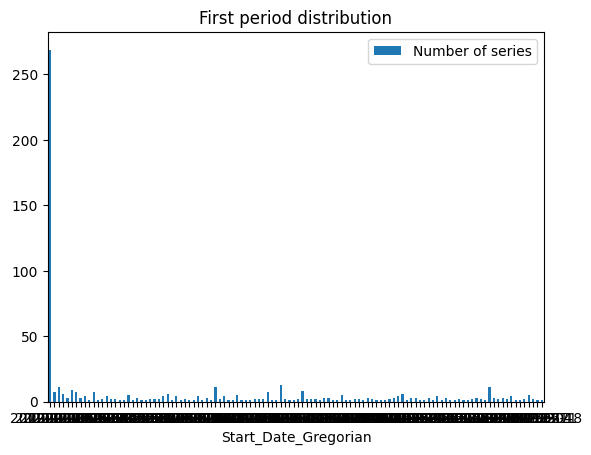

In [557]:
hist_start_dates_df = fin_summary_df.groupby('min_time_period').agg(count = (modeling_gran[0],'count')).reset_index()
hist_start_dates_df = hist_start_dates_df.sort_values(by = 'min_time_period', ascending = True)
hist_start_dates_df.columns = [date_col,'Number of series']
hist_start_dates_df[date_col] = hist_start_dates_df[date_col].astype(str)
hist_start_dates_df.plot.bar(x=date_col, y='Number of series', rot=0, title = 'First period distribution');

In [558]:
def correlation_distribution_with_target(
    df: pd.DataFrame,
    groupby_cols: list,
    target_col: str,
    input_cols: list,
    bucket_width: float = 0.1,
    called_from: str = "external",
):
   
    if called_from not in {"external", "internal"}:
        raise ValueError(
            f"called_from must be either 'external' or 'internal'; received {called_from} instead"
        )

    if called_from == "external":
        if not is_numeric_dtype(df[target_col].dtype):
            raise VariableTypeError(
                f"target_col - {target_col} - is not numerical; correlation requires numerical variables"
            )
        for inp_col in input_cols:
            if not is_numeric_dtype(df[inp_col].dtype):
                raise VariableTypeError(
                    f"{inp_col} in input_cols is not numerical; correlation requires numerical variables"
                )

    def target_corr(df, target_col, input_cols):
        # return df[input_cols].corrwith(df[target_col])
        target_col_variance = df[target_col].var(skipna=True)
        if pd.isna(target_col_variance) | (target_col_variance == 0):
            return pd.Series([np.nan] * len(input_cols), index=input_cols)
        s = df[input_cols].corrwith(df[target_col])
        cols_with_nan_result = list(s[s.isna()].index)
        for col in cols_with_nan_result:
            if ((s_nonna := df[[col, target_col]].notna().all(axis=1)).sum()) > 1:
                if (np.around(df[target_col][s_nonna].var(), 5) == 0) ^ (
                    np.around(df[col][s_nonna].var(), 5) == 0
                ):
                    s.loc[col] = 0.0
                elif (np.around(df[target_col][s_nonna].var(), 5) == 0) & (
                    np.around(df[col][s_nonna].var(), 5) == 0
                ):
                    pass
                else:
                    raise ValueError(
                        f"Unhandled reason for NaN as correlation in {col} at a particular granularity level"
                    )
        return s

    correlation_table = df.groupby(groupby_cols, sort=False)[
        [target_col, *input_cols]
    ].apply(func=target_corr, target_col=target_col, input_cols=input_cols)
    correlation_bucket = pd.DataFrame()
    bins = np.arange(start=-1.0, stop=1.0 + bucket_width, step=bucket_width).round(
        decimals=1
    )
    for col in input_cols:
        if (
            correlation_table[col].notna().any()
        ):  # if there is a single non-na value at any granularity level only then do correlation distribution generation; else leave out that column entirely.
            correlation_bucket[col] = (
                pd.cut(correlation_table[col], bins=bins, right=False)
                .value_counts(sort=False, normalize=True)
                .mul(100)
                .round(1)
            )
    if len(correlation_bucket.columns) == 0:
        raise InsufficientDataError(
            "Not enough non-null values to calculate correlation distribution for any column in input_cols"
        )

    return correlation_bucket.T.rename_axis(index="Variable").sort_index()

In [559]:
idvs

['log_SDV_new',
 'event_ind_Week_After_35_2023-07-04 00:00:00',
 'stateLevel_grocery_and_pharmacy_percent_change_from_baseline',
 'event_ind_Week_Of_40_Labor Day',
 'promotion_duration',
 'tpr_discount',
 'New_cases',
 'event_ind_Week_Of_25_Easter',
 'event_ind_Week_Before_20_Super Bowl',
 'event_ind_Week_Of_35_2023-07-04 00:00:00',
 'event_ind_Week_After_60_3_Wk_pfle_1',
 'event_ind_Week_After_20_Super Bowl',
 'event_ind_Week_Of_77_Disasters (code after event)',
 'event_ind_Week_Of_60_3_Wk_pfle_1',
 'APP',
 'event_ind_Week_After_99_Xmas/New Years',
 'event_ind_Week_Before_30_Memorial Day',
 'AvgUnitPrice',
 'minus_log_one_minus_perc_discount',
 'event_ind_Week_Of_20_Super Bowl',
 'event_ind_Week_Of_45_Thanksgiving',
 'log_SRP_new',
 'event_ind_Week_Of_99_Xmas/New Years',
 'event_ind_Week_Of_66_Region Event',
 'event_ind_Week_Of_30_Memorial Day',
 'event_ind_Week_Of_50_College Bowls/Fast Start',
 'event_ind_Week_After_40_Labor Day',
 'event_ind_Week_After_30_Memorial Day',
 'event_ind_

In [563]:
idvs = [col for col in idvs if col in bindc_data_with_start.columns]

In [569]:
df

,BDC,Category,BU,Class,Size,Start_Date_Gregorian,BinDC,data_classification,tot_sales_flg,tot_sales,...,event_ind_Week_Of_77_Disasters (code after event),event_ind_Week_Of_99_Xmas/New Years,APP,n_promotions,promotion_duration,min_Start_Date_Gregorian,minus_log_one_minus_perc_discount,log_one_plus_qty,log_SRP_new,log_SDV_new
0,1005182,8.0,99.0,1.0,5.0,2019-12-29,17483.0,Train,7,447.0,...,0,0,0.49,1.0,5.0,2019-12-29,3.912023,6.104793,-0.693147,NaN
1,1005182,8.0,99.0,1.0,5.0,2020-01-05,17483.0,Train,8,499.0,...,0,0,0.49,2.0,4.5,2019-12-29,3.912023,6.214608,-0.693147,NaN
2,1005182,8.0,99.0,1.0,5.0,2020-01-12,17483.0,Train,7,284.0,...,0,0,0.49,2.0,7.0,2019-12-29,3.912023,5.652489,-0.693147,NaN
3,1005182,8.0,99.0,1.0,5.0,2020-01-19,17483.0,Train,9,355.0,...,0,0,0.49,2.0,7.0,2019-12-29,3.912023,5.874931,-0.693147,NaN
4,1005182,8.0,99.0,1.0,5.0,2020-01-26,17483.0,Train,8,383.0,...,0,0,0.49,2.0,7.0,2019-12-29,3.912023,5.950643,-0.693147,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138980,192130039,7.0,192.0,192.0,130.0,2023-11-26,17483.0,Forecast,0,0.0,...,0,0,NaN,NaN,NaN,2022-04-10,NaN,0.000000,0.693147,0.182322
138981,192130039,7.0,192.0,192.0,130.0,2023-12-03,17483.0,Forecast,0,0.0,...,0,0,NaN,NaN,NaN,2022-04-10,NaN,0.000000,0.693147,0.182322
138982,192130039,7.0,192.0,192.0,130.0,2023-12-10,17483.0,Forecast,0,0.0,...,0,0,NaN,NaN,NaN,2022-04-10,NaN,0.000000,0.693147,0.182322
138983,192130039,7.0,192.0,192.0,130.0,2023-12-17,17483.0,Forecast,0,0.0,...,0,0,NaN,NaN,NaN,2022-04-10,NaN,0.000000,0.693147,0.182322


In [567]:
if(len(idvs)>0):
    # adjust the bucket_width according to the requirement
    bucket_width = 0.2
    cor_dist = correlation_distribution_with_target(df[df['data_classification']=='Train'],modeling_gran,dependent_var,\
                                         idvs,bucket_width,'external')
    cor_dist.columns = cor_dist.columns.add_categories(['Variable'])
    cor_dist = cor_dist.reset_index()
    cor_dist

In [579]:
cor_dist.to_csv('correlation.csv', index=False)

In [570]:
# update the below information according to the data
train_percentage = 0.7
no_of_backtesting_test_periods = 5
no_of_test_periods = 8
stride = 5
Total_data_points = 156 
backtesting_algo = 'expanding_window' #sliding_window/expanding_window


train_interval = int((Total_data_points-no_of_test_periods) * train_percentage)
train_period_ends = Total_data_points-no_of_test_periods
count = 0
train_index_start = 0
print('train_index_start','train_index_end','test_index_end')
for train_i in range(train_interval,train_period_ends,stride):
    if(train_i+no_of_backtesting_test_periods <=train_period_ends):
        test_i = train_i+no_of_backtesting_test_periods
        count = count+1
        if(backtesting_algo == 'sliding_window'):
            train_index_start = train_index_start+stride
        print(train_index_start,train_i,train_i+no_of_backtesting_test_periods)
        
print("Total iterations",count)

train_index_start train_index_end test_index_end
0 103 108
0 108 113
0 113 118
0 118 123
0 123 128
0 128 133
0 133 138
0 138 143
0 143 148
Total iterations 9
